In [136]:
#  Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from river import compose, preprocessing, linear_model, metrics, stream
import time
from collections import deque
import os
import joblib
plt.style.use('ggplot')


In [137]:
print('='*55)
print('Step 1: LOAD AND PREPARE DATA')
print('='*55)

Step 1: LOAD AND PREPARE DATA


In [138]:
# Load dataset
data = pd.read_excel('crop yield data sheet.xlsx', sheet_name='Sheet1').dropna()
X = data.drop(columns=['Yeild (Q/acre)'])
y = data['Yeild (Q/acre)']

# Split data (70% batch training, 30% streaming)
X_batch, X_stream, y_batch, y_stream = train_test_split(X, y, test_size=0.3, random_state=42)
print(data)

    Rain Fall (mm)  Fertilizer Temperatue  Nitrogen (N)  Phosphorus (P)  \
0           1230.0        80.0         28          80.0            24.0   
1            480.0        60.0         36          70.0            20.0   
2           1250.0        75.0         29          78.0            22.0   
3            450.0        65.0         35          70.0            19.0   
4           1200.0        80.0         27          79.0            22.0   
..             ...         ...        ...           ...             ...   
94          1250.0        77.0         28          78.0            23.0   
95           425.0        60.0         39          65.0            19.0   
96          1220.0        79.0         28          77.0            23.0   
97           480.0        65.0         36          68.0            21.0   
98          1230.0        80.0         28          80.0            24.0   

    Potassium (K)  Yeild (Q/acre)  
0            20.0            12.0  
1            18.0          

In [139]:
print('='*55)
print('Step 3: Batch Model Training (Random Forest)')
print('='*55)

Step 3: Batch Model Training (Random Forest)


Training Batch Model...

Batch Model Performance:
MAE: 0.60
R²: 0.88


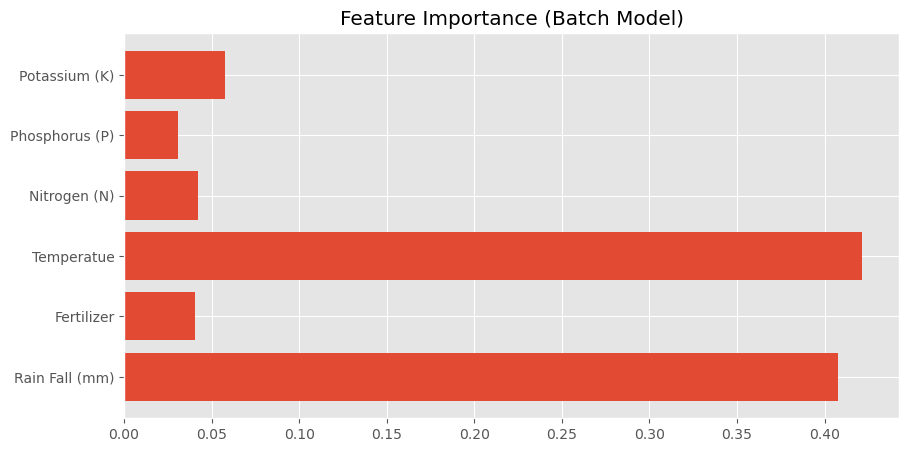

In [140]:

print("Training Batch Model...")
batch_model = RandomForestRegressor(n_estimators=100, random_state=42)
batch_model.fit(X_batch, y_batch)
joblib.dump(batch_model,'batch_model.sav')

# Evaluate
y_pred = batch_model.predict(X_stream)
print(f"\nBatch Model Performance:")
print(f"MAE: {mean_absolute_error(y_stream, y_pred):.2f}")
print(f"R²: {r2_score(y_stream, y_pred):.2f}")

# Feature Importance
plt.figure(figsize=(10,5))
plt.barh(X.columns, batch_model.feature_importances_)
plt.title("Feature Importance (Batch Model)")
plt.show()

In [141]:
print('='*55)
print ('Step 4: Online Learning Setup with River')
print('='*55)

Step 4: Online Learning Setup with River



Initializing Online Learning Model...


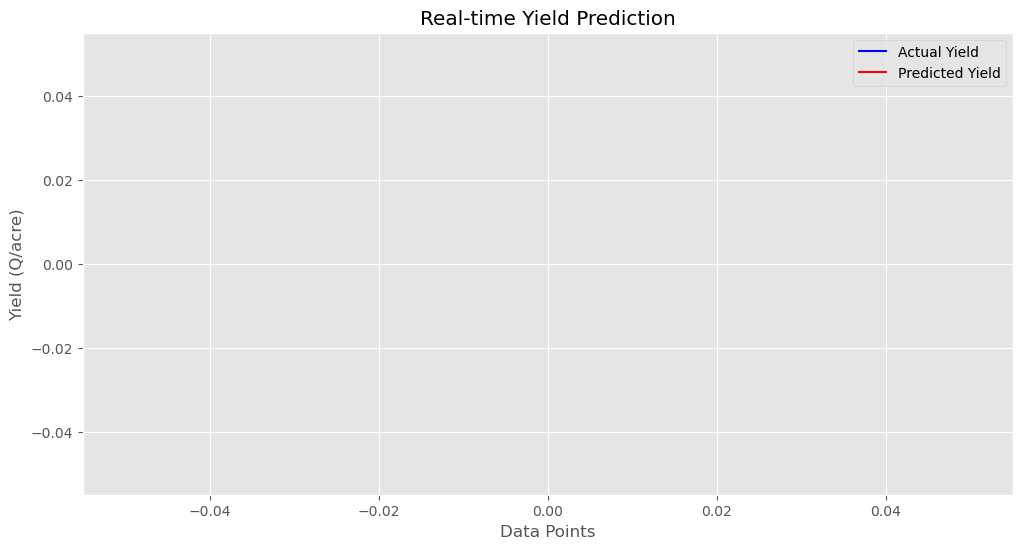

In [142]:
print("\nInitializing Online Learning Model...")
online_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)
metric = metrics.MAE()
joblib.dump(online_model,'online_model')
# Create a live plot
plt.figure(figsize=(12,6))
line1, = plt.plot([], [], 'b-', label='Actual Yield')
line2, = plt.plot([], [], 'r-', label='Predicted Yield')
plt.title('Real-time Yield Prediction')
plt.xlabel('Data Points')
plt.ylabel('Yield (Q/acre)')
plt.legend()
plt.grid(True)
plt.grid(True)

In [143]:
print('='*55)
print('Step 5: Simulated IoT Data Stream with Continuous Learning')
print('='*55)

Step 5: Simulated IoT Data Stream with Continuous Learning



Starting IoT Data Stream Simulation...


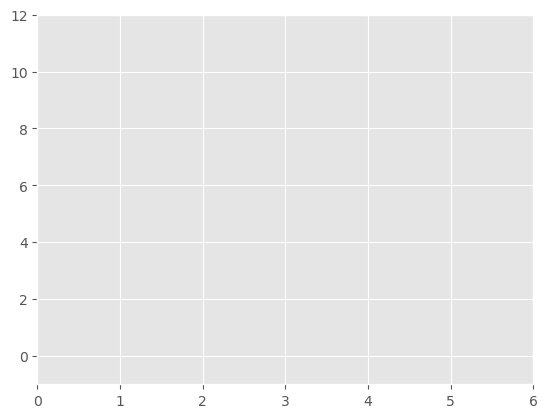

Processed 0 samples | Current MAE: 11.00


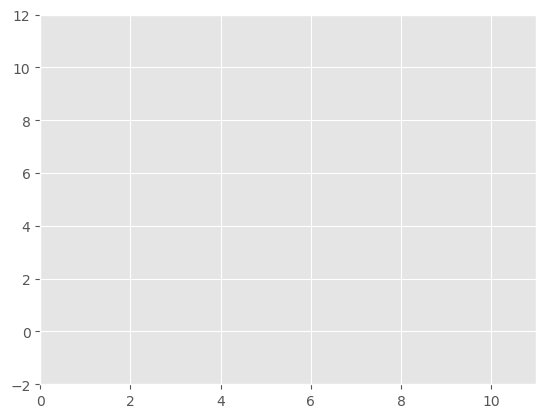

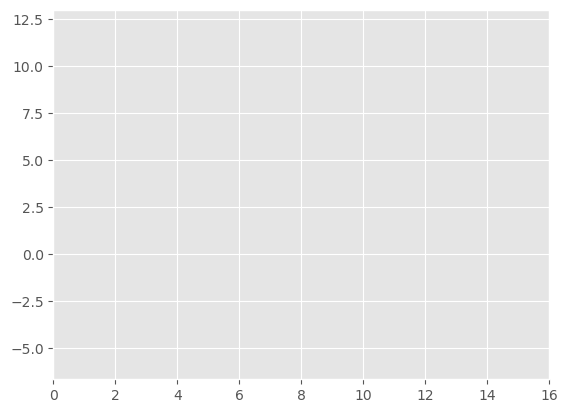

Processed 10 samples | Current MAE: 9.43


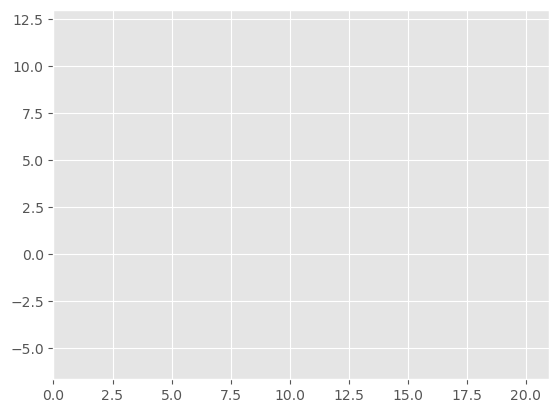

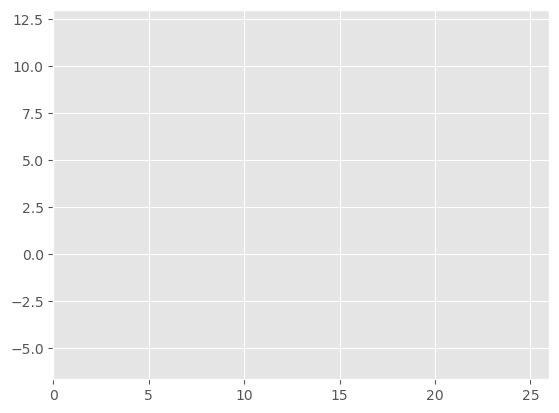

Processed 20 samples | Current MAE: 8.20


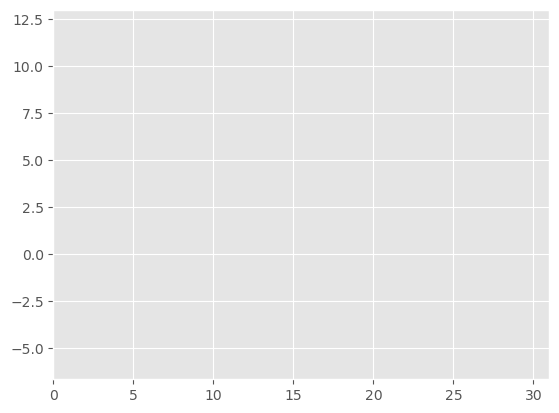


Final Online Model Performance:
MAE: 6.80


In [144]:

print("\nStarting IoT Data Stream Simulation...")
recent_actual = deque(maxlen=50)
recent_predicted = deque(maxlen=50)

for i, (xi, yi) in enumerate(stream.iter_pandas(X_stream, y_stream)):
    # Predict and update model
    y_pred_online = online_model.predict_one(xi)
    online_model.learn_one(xi, yi)
    metric.update(yi, y_pred_online)
    
    # Store results for visualization
    recent_actual.append(yi)
    recent_predicted.append(y_pred_online)
    
    # Update plot every 5 new points
    if i % 5 == 0:
        line1.set_data(np.arange(len(recent_actual)), recent_actual)
        line2.set_data(np.arange(len(recent_predicted)), recent_predicted)
        plt.xlim(0, len(recent_actual)+5)
        plt.ylim(min(min(recent_actual), min(recent_predicted))-1, 
                 max(max(recent_actual), max(recent_predicted))+1)
        plt.draw()
        plt.pause(0.1)
        
    # Print progress
    if i % 10 == 0:
        print(f"Processed {i} samples | Current MAE: {metric.get():.2f}")

# Final Performance
print("\nFinal Online Model Performance:")
print(f"MAE: {metric.get():.2f}")

In [145]:
print('='*55)
print('Step 6: Compare Both Models')
print('='*55)

Step 6: Compare Both Models



Model Comparison:


,Model,MAE,Adaptive
0,Batch (Random Forest),0.595111,No
1,Online (River),6.795851,Yes


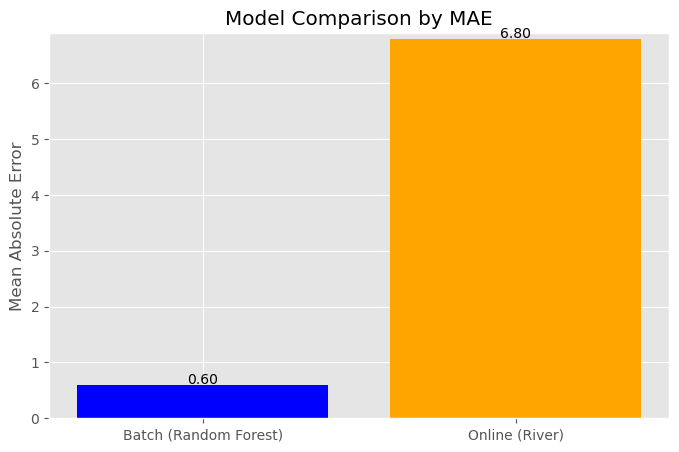

In [146]:
results = pd.DataFrame({
    'Model': ['Batch (Random Forest)', 'Online (River)'],
    'MAE': [mean_absolute_error(y_stream, y_pred), metric.get()],
    'Adaptive': ['No', 'Yes']
})

print("\nModel Comparison:")
display(results)

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['MAE'], color=['blue', 'orange'])
plt.title('Model Comparison by MAE')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, max(results['MAE'])+0.1)
for i, v in enumerate(results['MAE']):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.show()